In [ ]:
import sys
sys.path.append('C:\\Users\\user\\PycharmProjects\\pipeGEM')

from pathlib import Path
import cobra
import pandas as pd
import numpy as np
import pipeGEM as pg
from pipeGEM.utils import load_model, save_model, get_subsystems
from pipeGEM.integration.mapping import Expression
from pipeGEM.integration.constraints.GIMME import _GIMME_post_process
from pipeGEM.integration.constraints.RIPTiDe import RIPTiDe
from cobra.flux_analysis.parsimonious import pfba
from cobra.sampling import sample

%load_ext autoreload
%autoreload 2

In [40]:
model_path = "../models/2022Feb/"
mod_dict = {mod_name.stem: load_model(f"{mod_name}") for mod_name in Path(model_path).iterdir()}

In [6]:
data = pd.read_csv("../data/mg_TPMs.tsv", sep='\t')

data["gene"] = data["gene"].apply(lambda x: x[:x.index(".")] if "." in x else x)
data = data.groupby("gene").sum()

In [33]:
labels = pd.read_excel("../data/all_info/labels.xlsx", sheet_name="20220203")

In [36]:
gb = labels.groupby("group")["sample"].apply(lambda x: list(x))
groups = {f"G{i+1}": [g + "A" for g in gs] for i, gs in enumerate(gb)}
# groups["G3"].append("R016A.1")

In [37]:
groups

{'G1': ['R049A',
  'C002A',
  'C003A',
  'C004A',
  'C005A',
  'C006A',
  'C007A',
  'C008A',
  'C009A',
  'C010A',
  'C011A',
  'C012A'],
 'G2': ['R002A',
  'R003A',
  'R005A',
  'R008A',
  'R011A',
  'R017A',
  'R021A',
  'R025A',
  'R032A',
  'R047A',
  'R050A'],
 'G3': ['R004A', 'R006A', 'R016A', 'R027A', 'R029A', 'R030A', 'R045A'],
 'G4': ['R001A',
  'R007A',
  'R009A',
  'R010A',
  'R012A',
  'R013A',
  'R014A',
  'R015A',
  'R018A',
  'R019A',
  'R020A',
  'R022A',
  'R023A',
  'R024A',
  'R026A',
  'R028A',
  'R031A',
  'R033A',
  'R034A',
  'R035A',
  'R036A',
  'R037A',
  'R038A',
  'R039A',
  'R040A',
  'R041A',
  'R043A',
  'R044A',
  'R046A',
  'R048A',
  'R053A',
  'R054A']}

In [38]:
data.columns

Index(['C002A', 'C003A', 'C004A', 'C005A', 'C006A', 'C007A', 'C008A', 'C009A',
       'C010A', 'C011A', 'C012A', 'R001A', 'R002A', 'R003A', 'R004A', 'R005A',
       'R006A', 'R007A', 'R008A', 'R009A', 'R010A', 'R011A', 'R012A', 'R013A',
       'R014A', 'R015A', 'R016A', 'R016A.1', 'R017A', 'R018A', 'R019A',
       'R020A', 'R021A', 'R022A', 'R023A', 'R024A', 'R025A', 'R026A', 'R027A',
       'R028A', 'R029A', 'R030A', 'R031A', 'R032A', 'R033A', 'R034A', 'R035A',
       'R036A', 'R037A', 'R038A', 'R039A', 'R040A', 'R041A', 'R043A', 'R044A',
       'R045A', 'R046A', 'R047A', 'R048A', 'R049A', 'R050A', 'R053A', 'R054A'],
      dtype='object')

In [18]:
rxn_score_dict = {}
log2_data = np.log2(data)
log2_p_1_data = np.log2(data + 1)
for i, c in enumerate(data.columns):
    if c in mod_dict:
        exp = Expression(mod_dict[c], log2_p_1_data[c])
        rxn_score_dict[c] = exp.rxn_scores
    else:
        print("exclude ", c)

exclude  R016A.1
exclude  R037A
exclude  R038A
exclude  R039A
exclude  R040A
exclude  R041A
exclude  R043A
exclude  R044A
exclude  R045A
exclude  R046A
exclude  R047A
exclude  R048A
exclude  R049A
exclude  R050A
exclude  R053A
exclude  R054A


In [46]:
for i, c in enumerate(data.columns):
    if c in rxn_score_dict:
        continue
    elif c in mod_dict:
        exp = Expression(mod_dict[c], log2_p_1_data[c])
        rxn_score_dict[c] = exp.rxn_scores
    else:
        print("exclude ", c)

exclude  R016A.1


In [25]:
max(rxn_score_dict[c].values())

8.001087247018486

In [74]:
sol_dic = {}

for i, c in enumerate(data.columns):
    if c not in rxn_score_dict:
        continue
    
    with mod_dict[c] as mod:
        sol_v = mod.slim_optimize()
        obj_dic = {r.id : r.objective_coefficient for r in mod.reactions if r.objective_coefficient > 0}
        print(c, sol_v)
        
        RIPTiDe(mod,
                obj_frac=0.5,
                rxn_expr_score=rxn_score_dict[c],
                pruning_tol=1e-13,
                prune_rxns=True,
                return_pruning_coef=False
                )
        
        sol = mod.optimize(objective_sense="maximize")
        con = mod.problem.Constraint(mod.objective.expression, lb=sol.objective_value * 0.5)
        mod.add_cons_vars([con])
        
        mod.objective = {mod.reactions.get_by_id(r): v for r, v in obj_dic.items()}
        sol = pfba(mod)
        sol_df = _GIMME_post_process(sol)
        sol_df.to_frame().to_csv(f"../results/2022Feb/GEM/pfba/{c}.csv")
        
        
#         samp_df = sample(mod, n=500).T
#         for ind in samp_df.index:
#             if "_R_" in ind:
#                 samp_df.loc[ind, :] = -samp_df.loc[ind, :]
#         samp_df["rxn_id"] = samp_df.index.to_series().apply(lambda x: x[3:] if "_F_" in x or "_R_" in x else x)
#         samp_df = samp_df.groupby("rxn_id").sum()
#         samp_df.to_csv(f"../results/2022Feb/GEM/sampled/{c}.csv")

C002A 5.258268627416603
9493 reactions are non-core reactions (fluxes smaller than 1e-13)
C003A 5.258268627416508
7526 reactions are non-core reactions (fluxes smaller than 1e-13)
C004A 5.258268627416615
9083 reactions are non-core reactions (fluxes smaller than 1e-13)
C005A 5.258268627416595
9787 reactions are non-core reactions (fluxes smaller than 1e-13)
C006A 5.258268627416556
9411 reactions are non-core reactions (fluxes smaller than 1e-13)
C007A 5.2582686274165
9499 reactions are non-core reactions (fluxes smaller than 1e-13)
C008A 5.2582686274165935
9766 reactions are non-core reactions (fluxes smaller than 1e-13)
C009A 5.258268627416613
9601 reactions are non-core reactions (fluxes smaller than 1e-13)
C010A 5.258268627416621
10056 reactions are non-core reactions (fluxes smaller than 1e-13)
C011A 5.258268627416613
9651 reactions are non-core reactions (fluxes smaller than 1e-13)
C012A 5.25826862741789
9750 reactions are non-core reactions (fluxes smaller than 1e-13)
R001A 5.258

In [66]:
for i, r in mod_dict['R036A'].optimize().to_frame().iterrows():
    print(i, r.index, r["fluxes"])
    break

MAR03905 Index(['fluxes', 'reduced_costs'], dtype='object') 0.01


In [62]:
sol_dic['C006A'].loc["MAR06916", :]

AttributeError: 'Solution' object has no attribute 'loc'

In [56]:
for c, s in sol_dic.items():
    print(s.to_frame().loc["MAR06921", "fluxes"])

46.23047432895907
45.95550530415706
44.57132664006501
46.03431532628047
46.35476115536506
46.17074362549636
45.90177214774986
46.126518327778264
45.95255957297153
45.96372239091052
45.644726739676074
46.15850261508669
46.047011431153386
45.852077208388145
46.01993970522573
46.298745828653296
46.18617010253516
42.31619581939733
45.359122754488865
44.543866359508655
46.01182581818725
46.033433481063334
46.15127608840415
46.0832733881638
45.19744734996758
45.87004991547461
45.172058738111524
46.168465887525926
45.94188545562231
42.36349692005305
46.12957950370394
45.9904911708519
45.97617008703373
46.117465262738335
42.752708328990394
46.12624935910676
46.13041534760114
45.99437110833954
45.950735589001965
45.84988492767388
45.94785327311553
42.934204463746354
46.02818604557462
46.16375770729331
46.03165586823851
44.89410620580298
45.17288051508097


In [60]:
for c, e in rxn_score_dict.items():
    print(c, e["MAR06916"])

C002A 0.6172824946064297
C003A 0.6456066745705628
C004A 0.5928459294515158
C005A 0.4655869084823276
C006A 0.5482866752652256
C007A 0.43108161353361574
C008A 0.2582185958022704
C009A 0.323446165254313
C010A 0.3503727739071757
C011A 0.414511180269414
C012A 0.3852101291747311
R001A 0.918980746557612
R002A 0.4188473108105817
R003A 0.42674029596833785
R004A 0.5429850344048975
R005A 0.3927878020715615
R006A 0.20682448710265705
R007A 0.04501736887140039
R008A 0.2651139938877342
R009A 0.297286516827743
R010A 0.6833236631473152
R011A 0.12278865980574967
R012A 0.34865168051621453
R013A 0.33433142999788434
R014A 0.38794259056738
R015A 0.5057883118557364
R016A 0.17777495034492125
R017A 0.4461821078733035
R018A 0.39667135766726247
R019A 0.06005250401735238
R020A 0.09633918159947014
R021A 0.3359908196422812
R022A 0.2766098137554601
R023A 0.06659293467543449
R024A 0.11187677778175942
R025A 0.30601369907758896
R026A 0.13509365413062333
R027A 0.2314532991107633
R028A 0.38891910556126397
R029A 0.7661074

In [79]:
all_dfs = []

for i, c in enumerate(data.columns):
    if c not in rxn_score_dict:
        continue
    df = pd.read_csv(f"../results/2022Feb/GEM/pfba/{c}.csv", index_col=0)["fluxes"]
    df.name = c
    all_dfs.append(df)
    
mg_df = pd.concat(all_dfs, axis=1)

In [83]:
mg_df.fillna(0).to_csv("../results/2022Feb/ML/data/pfba.csv")

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
mg_df = mg_df.fillna(0)

,R049A,C002A,C003A,C004A,C005A,C006A,C007A,C008A,C009A,C010A,...,R038A,R039A,R040A,R041A,R043A,R044A,R046A,R048A,R053A,R054A
MAR00001,0.001163,0.001089,0.000838,0.001301,0.000840,0.000320,0.001107,0.000652,0.000167,0.001109,...,0.00105,0.001048,0.000933,0.001103,0.001093,0.000677,0.001197,0.000869,0.001074,0.001090
MAR00002,89.828037,84.146570,64.697666,100.466267,64.900568,24.714095,85.501227,50.371917,12.931394,85.652717,...,81.12186,80.919600,72.058970,85.223214,84.388371,52.271453,92.445551,67.110393,82.939342,84.225622
MAR00003,89.828037,84.146570,64.697666,100.466267,64.900568,24.714095,85.501227,50.371917,12.931394,85.652717,...,81.12186,80.919600,72.058970,85.223214,84.388371,52.271453,92.445551,67.110393,82.939342,84.225622
MAR00004,89.838037,84.156570,64.707666,100.476267,64.900568,24.724095,85.511227,50.381917,12.941394,85.662717,...,81.13186,80.929600,72.068970,85.233214,84.398371,52.281453,92.455551,67.120393,82.949342,84.235622
MAR00005,89.838037,84.156570,64.707666,100.476267,64.900568,24.724095,85.511227,50.381917,12.941394,85.662717,...,81.13186,80.929600,72.068970,85.233214,84.398371,52.281453,92.455551,67.120393,82.949342,84.235622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR08663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR08667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR08668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAR10393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

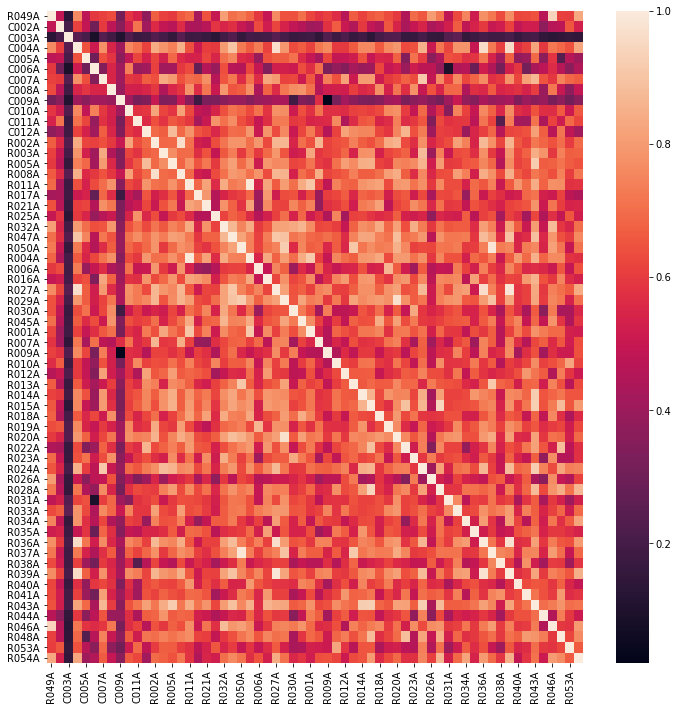

In [94]:
plt.figure(figsize=(12, 12))
sns.heatmap(mg_df[groups["G1"]+ groups["G2"]+ groups["G3"]+ groups["G4"]].corr())